In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Exploring Dataset #

In [202]:
reddit_df = pd.read_csv('Reddit_Data.csv')
# Printing size of our dataset
print ("Number of Samples:",len(reddit_df))
# Printing first 5 samples in our dataset
reddit_df.head(5)

Number of Samples: 37249


,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


Sample of what the data looks like:
    We can see that we have our actual text data and the category that it belongs to.
    1: Positive
    0: Neutral
   -1: Negative


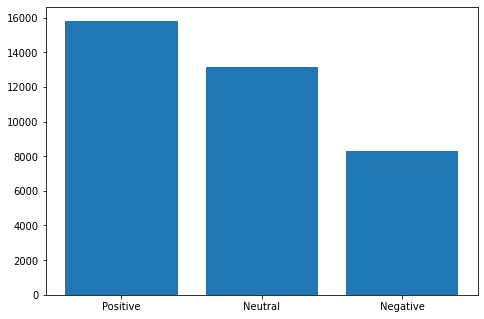

Positive: 15830 , Neutral: 13142 , Negative: 8277


In [203]:
def labelDistribution():
    labels = reddit_df["category"].to_numpy()
    neg_count = 0
    pos_count = 0
    neu_count = 0
    for i in labels:
        if i == -1:
            neg_count+=1
        elif i == 1:
            pos_count+=1
        else:
            neu_count+=1

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    categories = ['Positive', 'Neutral', 'Negative']
    counts = [pos_count, neu_count, neg_count]
    ax.bar(categories, counts)
    plt.show()
    print ("Positive:", pos_count, ", Neutral:", neu_count, ", Negative:", neg_count)
    
labelDistribution()

As we can see around __42%__ of the dataset is comprised of positive comments, around __35%__ is comprised of neutral comments, and around
__22%__ is comprised of negative comments.

Let us explore the number of unique words in our data set.

In [204]:
word_dict = dict()
def getNumUniqueWords():
    word_index = 0
    for comment in reddit_df["clean_comment"]:
        split_comment = str(comment).split()
        for word in split_comment:
            word_dict[word] = word_dict.get(word, 0) - 1
    print ("Number of unique words: ", len(word_dict))
getNumUniqueWords()

Number of unique words:  54732


# Pre-processing of Data Set  #

Since our data set is skewed towards positive and neutral comments
I think it would be beneficial to undersample positive and neutral
comments so our data is more evenely distributed.

In [205]:
# Random Undersampling of Positive and Neutral Comments

reddit_df_pos = reddit_df[reddit_df["category"] == 1].sample(frac=.68)
reddit_df_neu = reddit_df[reddit_df["category"] == 0].sample(frac=.80)
reddit_df_neg = reddit_df[reddit_df["category"] ==-1].sample(frac=1)

reddit_df = reddit_df_pos.append(reddit_df_neu).append(reddit_df_neg)


/var/folders/s8/h_031z5d7mbf8ckkr3tnb9rw0000gn/T/ipykernel_1351/1316555105.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reddit_df = reddit_df_pos.append(reddit_df_neu).append(reddit_df_neg)
/var/folders/s8/h_031z5d7mbf8ckkr3tnb9rw0000gn/T/ipykernel_1351/1316555105.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reddit_df = reddit_df_pos.append(reddit_df_neu).append(reddit_df_neg)


Let's now see the data distributions again.

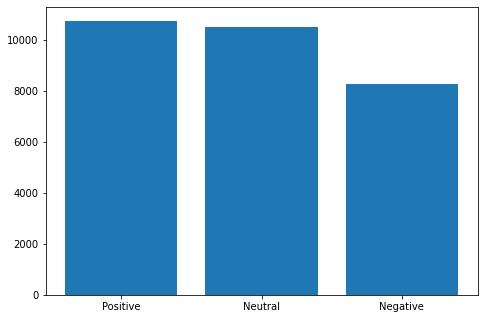

Positive: 10764 , Neutral: 10514 , Negative: 8277


In [206]:
labelDistribution()

Let's also see how many unique words we lost when we undersampled our dataset

In [207]:
word_dict = dict()
getNumUniqueWords()

Number of unique words:  48559


In [191]:
print ("Number of samples after undersampling: ", len(reddit_df))

Number of samples after undersampling:  29555


We originally started with 37249 samples and
have reduced our dataset to 29555 which is almost a 20% reduction of data.

We originally started with 54732 unique words and
have reduced our dataset to 48559 which is almost a ~12% reduction of unique words.

By evenly distributing our dataset in terms of labels, we have lost some uniqueness in features. 
Hopefully this trade off pays off in a more generalized model.

# Feature Extraction #

For Feature Extraction I would like to build a classification model
that will correctly predict sentiment (-1,0,1) based on the frequency
of the most common words in our dataset. 

I would like to find the most frequent words to build our feature set.

In [208]:
count = 0
for k, v in sorted(word_dict.items(), key=lambda item: item[1]):
    if count < 10:
        print (k, v)
        count+=1
    else:
        break

the -45040
and -22696
that -11932
this -10640
for -10146
you -9091
are -8399
not -6938
they -6911
have -6589


As we can see there is a significantly more usages of the words "the" and "and"
hence these are outliers that I will remove from the set.

In [209]:
word_dict.pop('the')
word_dict.pop('and')
count = 0
for k, v in sorted(word_dict.items(), key=lambda item: item[1]):
    if count < 10:
        print (k, v)
        count+=1
    else:
        break

that -11932
this -10640
for -10146
you -9091
are -8399
not -6938
they -6911
have -6589
with -6147
but -5653


Let's now select the top 2500 words from out dictionary and assign it a number.

In [210]:
feature_set = {}
count = 0
for k, v in sorted(word_dict.items(), key=lambda item: item[1]):
    if count < 2500:
        feature_set[k] = count
        count+=1
    else:
        break

In [211]:
print (len(feature_set))

2500


Let's now create each frequency feature vector for each Reddit Comment.

In [212]:
features_encoded = []

for comment in reddit_df["clean_comment"]:
    split_comment = str(comment).split()
    curr_feature_vect = np.full((1, 2500), 0)
    for word in split_comment:
        index = feature_set.get(word, -1)
        if index != -1:
            curr_feature_vect[0, index] = curr_feature_vect[0, index] + 1
    features_encoded.append(curr_feature_vect)

reddit_df["clean_comment_code"] = features_encoded

In [213]:
print (len(reddit_df))

29555


Randomly shuffle our dataset.

In [218]:
reddit_df = reddit_df.sample(frac=1)
X = reddit_df["clean_comment_code"].to_numpy()
X = np.stack(X)
X = np.reshape(X, (29555,2500))

In [219]:
print (X.shape)

(29555, 2500)


Let's see what our data looks like now, that each comment is encoded.

In [220]:
print (reddit_df.head(5))

                                           clean_comment  category  \
34660                          vivirock 2016 看来键盘侠不分国界\n         0   
495     you wondering whether girl will get through t...         1   
32202        she will change her name smriti hindustani          0   
25801  seriously why are they taking this much time a...        -1   
4737   behind all the facade pretty crass remember th...        -1   

                                      clean_comment_code  
34660  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
495    [[0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,...  
32202  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...  
25801  [[0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...  
4737   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...  


Let's now normalize the frequency feature vector so we have an easier time training our model. We are going to normalize our feature vector as a Gaussian with 0 mean and unit variance.

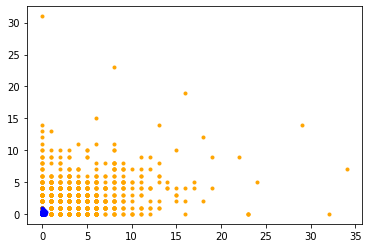

In [221]:
from sklearn.preprocessing import StandardScaler

# plot first two features before normalization
plt.plot(X[:,0], X[:,1], '.', color="orange")

# normalize
normalize = StandardScaler()
normalize.fit(X)
X = scaler.transform(X)

# let's now plot first two features and see what they look like after normalization
plt.plot(X[:,0], X[:,1], '.', color="blue")

In the plot, I have plotted the first two features of our frequency feature vector against each other.

The orange represents the features before normalization.
The blue represents the features after normalization.

# Processing of each dataset using two different machine learning methods. #

For this classification task I would like to use a __Naive Bayes__ model and a __Support Vector Machine__ model.

Split our train and test dataset. 
    - __70%__ of the dataset will be split for training.
    - __30%__ of the dataset will be split for testing.

In [222]:
from sklearn.model_selection import train_test_split

# extracting labels
Y = reddit_df["category"].to_numpy()

# Splitting Training and Testing Dataset and Labels
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)


## Naive Bayes ##

Naive Bayes is based on the assumption that all of our features in this data set are independent. So in our case we assume that each value in a word frequency vector is independent from each other. What we really want to learn in these generative learning algorithims is the probability of X given Y. Hence we find the log likelyhood of P(X/Y) and optimize on it. Once we have optimized the log likelyhood of P(X/Y) we have a decision boundary that allows us to accurately predict whether or not our features fall into a distribution that produces a positive comment, a negative comment, or a neutral comment. 

Here we are going to do 10 fold cross validation to get a good estimate of our models performance using Naive Bayes.

Parameters of our Naive Bayes Model is set as default defined by sklearn.
   
   - priors=None, var_smoothing=1e-09

## Train/Test ##

In [246]:
import time
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


naive_bayes = GaussianNB()

# train
cross_val_NB = KFold(n_splits=10, random_state=1, shuffle=True)

start_time_nb = time.time()
scores_NB = cross_val_score(naive_bayes, X, Y, scoring='accuracy', cv=cross_val_NB, n_jobs=-1)
print ("--- training/validation time Naive Bayes: %s seconds ---" % (time.time() - start_time_nb))
print ()
print ("Test Accuracy for 10 cross validation runs:\n", scores_NB)
print ()
print ("Mean Test Accuracy:", np.mean(scores_NB))

--- training/validation time Naive Bayes: 5.034670829772949 seconds ---

Test Accuracy for 10 cross validation runs:
 [0.63464141 0.64715832 0.63227334 0.63261164 0.62110961 0.63722504
 0.66226734 0.64230118 0.63824027 0.63045685]

Mean Test Accuracy: 0.637828501038354


## Support Vector Machine ##

Support Vector Machines are a classifer that's main goal is to find the best hyperplane/classifier that maximizes the margin between the support points. Meaning that we want to find the best linear seperator between our data. 

Once we get the langrangian of our optimization function. We optimize to find the appropriate weights for our hyperplane.

Here we are going to do 10 fold cross validation to get a good estimate of our models performance using Support Vector Machine algorithm.

## Train/Test ##

In [247]:
from sklearn.svm import LinearSVC

svm = LinearSVC(max_iter=10000)

# train
cross_val_SVM = KFold(n_splits=10, random_state=1, shuffle=True)

start_time_svm = time.time()
scores_SVM = cross_val_score(svm, X, Y, scoring='accuracy', cv=cross_val_SVM, n_jobs=-1)
print ("---training/validation time SVM: %s seconds ---" % (time.time() - start_time_svm))
print () 
print ("Test Accuracy for 10 cross validation runs:\n", scores_SVM)
print ()
print ("Mean Test Accuracy:", np.mean(scores_SVM))

---training/validation time SVM: 15.186454057693481 seconds ---

Test Accuracy for 10 cross validation runs:
 [0.84303112 0.84032476 0.8376184  0.83592693 0.83558863 0.83790186
 0.83079526 0.83553299 0.84365482 0.8321489 ]

Mean Test Accuracy: 0.8372523692097751


## Analysis Between Naive Bayes and SVM ##

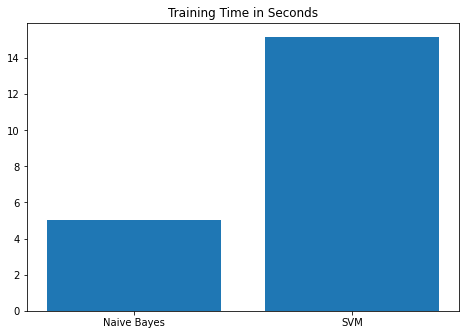

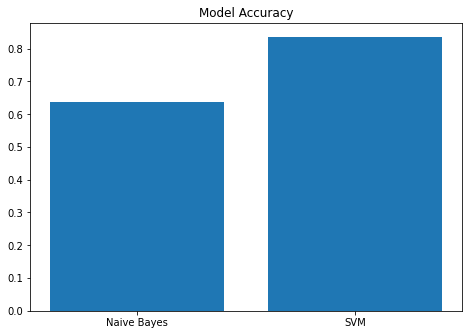

In [251]:
# Training Time Analysis
time_fig = plt.figure()
ax = time_fig.add_axes([0,0,1,1])
categories = ['Naive Bayes', 'SVM']
counts = [5.034, 15.186]
ax.bar(categories, counts)
plt.title('Training Time in Seconds')
plt.show()

# Accuracy Analysis
acc_fig = plt.figure()
ax = acc_fig.add_axes([0,0,1,1])
categories = ['Naive Bayes', 'SVM']
counts = [0.637, 0.837]
ax.bar(categories, counts)
plt.title('Model Accuracy')
plt.show()

As we can see Naive Bayes took the shortest training time but was lacking in classification accuracy. This can be attributed to many things.


    For one, with Naive Bayes we made a very big assumption. We assumed that the features were independent of eachother. We all know that the words in a sentence or a comment are dependent on one another. 
    
    Secondly, Naive Bayes and SVM both devise hyperplanes to make classification predictions. But SVM picks the linear seperator that maximizes the distance between classes and the hyperplane. Hence SVM will always converge on the optimal hyperplane while Naive Bayes does not. 